In [10]:
import numpy as np
import findiff
import matplotlib.pyplot as plt
# %matplotlib
# pyplot.ion

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "mathptmx", 
    "font.size": 14
})


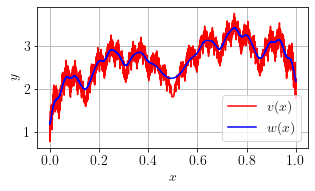

In [15]:
gamma = 0.8
sigma = 0.01
N = 15000
x0 = np.linspace(0,1,N,endpoint=True)

def project(x):
    return np.clip(x,0,1)

def eps():
    return np.random.normal(0,sigma,size=N)

def Phi(x):
    x = project(x)
    return 4*x*(1-x)

v = np.zeros_like(x0)
w = np.zeros_like(x0)
M = 10000 # the larger M, the better the estimate of w. the estimate of v converges quickly
for n in range(M):
    # estimate v
    v_next = v[(Phi(x0)*(N-1)).astype(int)]
    v = x0 + gamma * v_next

    # TD learning for estimating w
    T = 500
    if n < T: alpha = 1 # use this to estimate the mean correctly
    else: alpha = 1/(n-T+1) # use this to reduce the variance afterwards
    w_next = w[(Phi(x0+eps())*(N-1)).astype(int)]
    w = (1-alpha)*w + alpha*(x0 + gamma * w_next)

fig, ax = plt.subplots(1,1,figsize=(4*1.15,2.5*1.15))
cutoff = 5
ax.plot(x0[cutoff:-cutoff], v[cutoff:-cutoff], "-", color="red", label=f"$v(x)$")
ax.plot(x0[cutoff:-cutoff], w[cutoff:-cutoff], "-", color="blue", label=f"$w(x)$")

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig("./value_function_weierstrass.pdf")
plt.show()

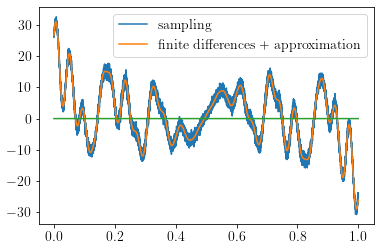

In [12]:
# computing the derivative by sampling from the expectation
dw = np.zeros_like(x0)
M = 50000
for n in range(M):
    e = eps()
    w_next = w[(Phi(x0+e)*(N-1)).astype(int)]
    dw += (1 + gamma * (e/sigma**2) * w_next) / M

# do a linear approximation to w in order to approximate its derivative a bit better
centers = np.linspace(0,1,100).reshape(-1,1)
bandwidth = 0.001
psi = lambda x: np.exp(-(centers-x)**2 / bandwidth).T
psi_x = psi(x0)
theta = np.linalg.lstsq(psi_x, w, rcond=1e-5)[0]
dw_findiff = findiff.FinDiff(0, 1/N, 1, acc=2)(psi_x @ theta)

plt.plot(x0, dw, label=f"sampling")
plt.plot(x0, dw_findiff, label=f"finite differences + approximation")
plt.plot(x0, np.zeros_like(x0))
plt.legend()
plt.show()